In [8]:
import splat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib
import wisps
import wisps.simulations as wispsim
import seaborn as sns
import matplotlib.colors as mcolors

from astropy.coordinates import SkyCoord
import astropy.coordinates as astrocoord
import astropy.units as u

import matplotlib as mpl
mpl.rcParams['font.size'] = 18
%matplotlib inline

In [9]:
#MIX MY COLORMAP WITH COOOLWARM 
colors1 = plt.cm.coolwarm(np.linspace(0., 1, 256))
colors2=plt.cm.YlOrBr(np.linspace(0., 1, 256))
colors = np.vstack((colors1+colors1)/2)
mymap=mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [10]:
mymap_r=mymap.reversed(name='revers')

In [11]:
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.Series(x.indices)
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]
    
def classify_by_templates(s):
    spt=s.spectral_type[0]
    spt_unc=s.spectral_type[1]
    if spt_unc== 0.0: spt_unc=1
        
    if spt<20:
        pass
        
    return 

def reclassify(s):
    if s is None:
        return None
    spt_unc=s.spectral_type[1]
    
    if abs(spt_unc) > 1:
        s.classify_by_standard(comprange=[1.15, 1.65])
        s.calculate_distance(use_spt_unc=True, use_index_type=False)
        
    return s
    


In [12]:
#read in the data
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.h5', key='all')

In [57]:
spectra= [reclassify(x) for x in cands0.spectra]

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [58]:
cands0['spectra']=spectra

In [59]:
cands=cands0.spectra.apply(get_indices)
cands['spectra']=cands0.spectra

<ipython-input-11-62a6b782f907>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series({})


In [60]:
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)

In [61]:
canddf=cands[~cands.spectra.isna()].reset_index(drop=True)

In [62]:
canddf['spt']=canddf.spectra.apply(lambda x: x.spectral_type[0])
canddf['spt_er']=canddf.spectra.apply(lambda x: x.spectral_type[1])
canddf['distance']=canddf.spectra.apply(lambda x: x.distance['val'].value)
canddf['distance_er']=canddf.spectra.apply(lambda x: x.distance['er'].value)
canddf['coord']=canddf.spectra.apply(lambda x:x.coords)
#canddf['index_type']=canddf.spectra.apply(lambda x: x.index_type[0])
#canddf['index_type_er']=canddf.spectra.apply(lambda x: x.index_type[1])

In [63]:
canddfj=canddf.join(canddf.spectra.apply(lambda x: pd.Series(x.mags)))
canddff=canddfj.join(canddf.spectra.apply(lambda x: pd.Series(x.snr)))
canddff['spectra']=canddf.spectra

In [64]:
ucds=wisps.Annotator.reformat_table((canddff[(canddff.spt>=17) &(canddff.snr1 >=3.)]).reset_index(drop=True)).sort_values(by='spt')

In [65]:
#remove some objects by name
ucds=(ucds[~ ucds.grism_id.isin(['par199-00124'])]).reset_index(drop=True).sort_values(by='spt')

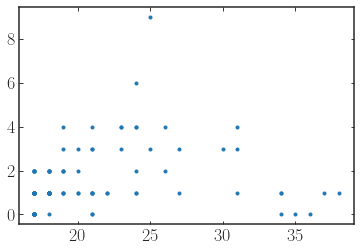

In [66]:
fig, ax=plt.subplots()
plt.plot(ucds.spt, ucds.spt_er, '.')

In [67]:
mdwarfs=(ucds.sort_values('spt')[ucds.spt.between(17, 20)])
ldwarfs=(ucds.sort_values('spt')[ucds.spt.between(20, 30)])
tdwarfs=(ucds.sort_values('spt')[ucds.spt.between(30, 40)])

coords=SkyCoord(ucds.coord.values)

galoc=coords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))
x, y, z=galoc.cartesian.xyz

r=(x**2+y**2)**0.5

ucds['pointing']=ucds.grism_id.apply(wispsim.get_proper_pointing)
pntcoords=SkyCoord([x.coord for x in wisps.OBSERVED_POINTINGS 
                    if not (x.name.lower() in ucds.pointing.str.lower().values)])

<ipython-input-67-185bb5d2c229>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mdwarfs=(ucds.sort_values('spt')[ucds.spt.between(17, 20)])
<ipython-input-67-185bb5d2c229>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ldwarfs=(ucds.sort_values('spt')[ucds.spt.between(20, 30)])
<ipython-input-67-185bb5d2c229>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdwarfs=(ucds.sort_values('spt')[ucds.spt.between(30, 40)])
/opt/anaconda3/lib/python3.8/site-packages/astropy/coordinates/builtin_frames/galactocentric.py:359: AstropyDeprecationWarning: In v4.1 and later versions, the Galactocentric frame will adopt default parameters that may update with time. An updated default parameter set is already available through the astropy.coordinates.galactocentric_frame_defaults ScienceState object, as described in but the default is currently still set to the pre-v4.0 parameter defaults. The safest way 

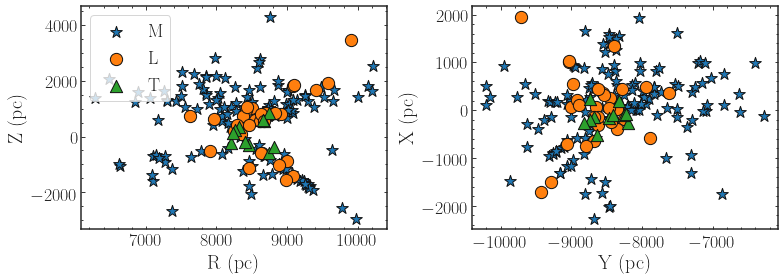

In [68]:
fig, (ax, ax1)=plt.subplots(figsize=(11, 4), ncols=2)

sc=ax.scatter(r[mdwarfs.index], z[mdwarfs.index], s=150, cmap='coolwarm',  marker='*', edgecolors='#111111', label='M')
sc=ax.scatter(r[ldwarfs.index], z[ldwarfs.index], s=150, cmap='coolwarm',  marker='o', edgecolors='#111111', label='L')
sc=ax.scatter(r[tdwarfs.index], z[tdwarfs.index], s=150, cmap='coolwarm',  marker='^', edgecolors='#111111', label='T')

ax.minorticks_on()

sc=ax1.scatter(x[mdwarfs.index], y[mdwarfs.index], s=150, cmap='coolwarm',  marker='*', edgecolors='#111111')
sc=ax1.scatter(x[ldwarfs.index], y[ldwarfs.index], s=150, cmap='coolwarm',  marker='o', edgecolors='#111111')
sc=ax1.scatter(x[tdwarfs.index], y[tdwarfs.index], s=150, cmap='coolwarm',  marker='^', edgecolors='#111111')

ax.minorticks_on()



ax.set_ylabel('Z (pc)', fontsize=20)
ax.set_xlabel('R (pc)', fontsize=20)
ax1.set_ylabel('X (pc)', fontsize=20)
ax1.set_xlabel('Y (pc)', fontsize=20)

ax.minorticks_on()
ax1.minorticks_on()


#add the sun
#Rsun=83000.
#Zsun=27.

#ax1.scatter(0., 0.)
#ax.scatter(8300, 27., marker='')
ax.legend()
#plt.grid(color='#7FDBFF')
#mplcyberpunk.make_lines_glow(ax)
#mplcyberpunk.make_lines_glow(ax1)


plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf', bbox_inches='tight')

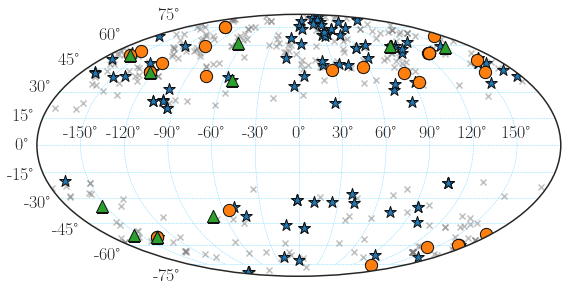

In [69]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(pntcoords.galactic.l.wrap_at(180*u.deg).radian, pntcoords.galactic.b.wrap_at(180*u.deg).radian, c='grey', marker='x', alpha=0.5)

c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[mdwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[mdwarfs.index], 
             marker='*', edgecolors='#111111', s=150)
c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[ldwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[ldwarfs.index], 
             marker='o', edgecolors='#111111', s=150)
c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian[tdwarfs.index], galoc.galactic.b.wrap_at(180*u.deg).radian[tdwarfs.index], 
             marker='^', edgecolors='#111111', s=150)




             

#plt.xlabel("l", fontsize=18)
#plt.ylabel("b", fontsize=18)
plt.grid(color='#7FDBFF')
plt.minorticks_on()
#mplcyberpunk.make_lines_glow(ax)

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_skymap.pdf', bbox_inches='tight')

In [70]:
fdf=ucds.sort_values(by='spt')[['grism_id', 'distance', 'spt','spectra']]

In [71]:
latc_df=pd.DataFrame()

In [72]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(x.spectral_type[1]))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: str(int(round(x.distance['val'].value, 0)))  + r'$\pm$'+ 
                                                 str((int(round(x.distance['er'].value, 0)))))

In [73]:
latc_df=latc_df.replace('nan$\\pm$nan', 'nodata')

In [74]:
#get the right sequence of coplumns
col_list=['designation','grism id', 'ra', 'dec', 'f110', 'f140', 'f160', 'snrj', 'spt', 'distance']

In [75]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [76]:
fdf=fdf.reset_index(drop=True)

#########################

In [77]:
spdwarf=splat.searchLibrary(giant=False, ucd=True, binary=False)
spdwarf.shortname=spdwarf.DESIGNATION.apply(splat.designationToShortName)
spdwarf=spdwarf[~ ( spdwarf.shortname.isin(wisps.FORBIDDEN_LIST)
               | (spdwarf.H_2MASS_E > 0.4) | (spdwarf.J_2MASS_E > 0.4) | (spdwarf.MEDIAN_SNR <3) )]
#spdwarf=spdwarf[~spdwarf.]
spdwarf.SPEX_TYPE=spdwarf.SPEX_TYPE.apply(wisps.make_spt_number)

/Users/caganze/research/splat/splat/core.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_db['SELECT'][source_db['OBJECT_TYPE'] != oc.upper()] += 1
/Users/caganze/research/splat/splat/core.py:3692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_db['SELECT'][source_db['BINARY_FLAG'] == kwargs.get('binary')] += 1
<ipython-input-77-afd23481c09a>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  spdwarf.shortname=spdwarf.DESIGNATION.apply(splat.designationToShortName)


In [78]:
def format_jk_zhang(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if row['J'] !='none':
        #print ((row['J']).split('±'))
        #row['J_mag']=(row['J']).split('±')[0]
        #row['J_er']=(row['J']).split('±')[-1]
        jmag=(row['J']).split('±')[0]
        jmag_er=(row['J']).split('±')[1]
        
    if row['H'] !='none':
        #print ((row['H']).split('±'))
        #row['H_mag']=(row['H']).split('±')[0]
        #row['H_er']=(row['H']).split('±')[-1]
        hmag=(row['H']).split('±')[0]
        hmag_er=(row['H']).split('±')[1]
        
    spt=splat.typeToNum(row[' SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

def format_jk_manj(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if str(row['J (mag)']) !='nan':
        #ignore others
        if not str(row['J (mag)']).startswith('>'):
            jmag=((row['J (mag)']).split('+or-')[0]).strip()
            jmag_er=((row['J (mag)']).split('+or-')[1]).strip()

    if str(row['H (mag)']) !='nan':
        if not str(row['J (mag)']).startswith('>'):
            hmag=(row['H (mag)']).split('+or-')[0]
            hmag_er=(row['H (mag)']).split('+or-')[1]
        
    spt=splat.typeToNum(row['SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

In [79]:
fdf=ucds
pols=wisps.POLYNOMIAL_RELATIONS
color_pol=pols['colors']

In [80]:
#zhang
zhng=pd.read_csv('~/research/wisps/data/zhang_data.csv')
zhng_clrs=zhng.apply(format_jk_zhang, axis=1 ).applymap(float)

In [81]:
#manjavacas
man_df0=pd.read_csv('/users/caganze/research/wisps/data/manjavaca_phot.txt', sep='\t',  index_col=None)
man_clrs=man_df0.apply(format_jk_manj, axis=1 ).applymap(float)

In [82]:
man_clrs.columns

Index(['H', 'J', 'H_er', 'J_er', 'SpTn'], dtype='object')

In [83]:
fdf['J']=fdf['F140W']+color_pol['j_f140'][0](fdf['spt'])
fdf['J_er']=(fdf['F140W_er']**2+color_pol['j_f140'][1]**2)**0.5

fdf['H']=fdf['F160W']+color_pol['h_f160'][0](fdf['spt'])
fdf['H_er']=(fdf['F160W_er']**2+color_pol['h_f160'][1]**2)**0.5

In [84]:
fdf['J_110']=fdf['F110W']+color_pol['j_f110'][0](fdf['spt'])
fdf['J_110_er']=(fdf['F110W_er']**2+color_pol['j_f110'][1]**2)**0.5

In [85]:
ucd_wisp=fdf[fdf.grism_id.str.startswith('par')]
ucd_hst3d=fdf[~fdf.grism_id.str.startswith('par')]

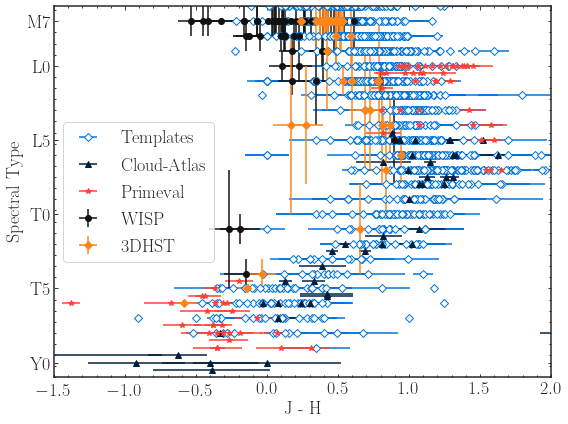

In [86]:
fig, ax=plt.subplots(figsize=(8, 6))



ax.errorbar(spdwarf['J_2MASS']-spdwarf['H_2MASS'], spdwarf.SPEX_TYPE, fmt='D', 
            xerr=(spdwarf.J_2MASS_E**2+spdwarf.H_2MASS_E**2)**0.5, color='#0074D9', 
            mfc='white',  label='Templates')

#ax.errorbar(spsubdwarf['J_2MASS']-spsubdwarf['H_2MASS'],spsubdwarf.SPEX_TYPE, fmt='D', 
#            xerr=(spsubdwarf.J_2MASS_E**2+spsubdwarf.H_2MASS_E**2)**0.5, color='#2ECC40', mfc='white', label='Spex Subdwarfs')

ax.errorbar(-man_clrs['J']+man_clrs['H'], man_clrs['SpTn'], fmt='^', 
            xerr=(man_clrs['J_er']**2+man_clrs['H_er']**2)**0.5, color='#001f3f', label='Cloud-Atlas')

ax.errorbar(-zhng_clrs['J']+zhng_clrs['H'],zhng_clrs.SpTn, fmt='*', 
            xerr=(zhng_clrs.J_er**2+zhng_clrs.H_er**2)**0.5, color='#FF4136', label='Primeval')



ax.errorbar(ucd_wisp['J_110']-ucd_wisp['H'], ucd_wisp['spt'], fmt='o', 
            xerr=(ucd_wisp['J_110_er']**2+ucd_wisp['H_er']**2)**0.5, 
            yerr=ucd_wisp['spt_er'], color='#111111', label=r'WISP')

ax.errorbar(ucd_hst3d['J']-ucd_hst3d['H'], ucd_hst3d['spt'], fmt='D',
            xerr=(ucd_hst3d['J_er']**2+ucd_hst3d['H_er']**2)**0.5, 
            yerr=ucd_hst3d['spt_er'], color='#FF851B', label=r'3DHST')


ax.set_ylim([16, 41])
ax.set_xlim([-1.5, 2])
ax.invert_yaxis()


ax.set_yticks([17, 20, 25, 30, 35, 40])
ax.set_yticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])


ax.minorticks_on()
ax.set_ylabel('Spectral Type', fontsize=18)
ax.set_xlabel(r'J - H', fontsize=18)

ax.legend(fontsize=18)
#mplcyberpunk.make_lines_glow(ax)
#plt.grid(which='both', color='#7FDBFF')
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/color_color_plots.pdf', bbox_inches='tight')


In [87]:
wispsucd=ucds[ucds.grism_id.str.lower().str.startswith('par')]
hst3ducd=ucds[~ucds.grism_id.str.lower().str.startswith('par')]

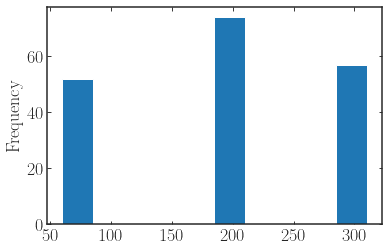

In [88]:
ucds.spectra.apply(lambda x: x.dof).plot(kind='hist')

In [89]:

maglimits=pd.DataFrame([x.mag_limits for x in wisps.OBSERVED_POINTINGS])

In [90]:
maglimits.median()+ 3*maglimits.std()

F110    23.054573
F140    23.822972
F160    23.367867
dtype: float64

In [91]:
sp_grid=np.arange(15, 40)

d_limitsdict=(pd.DataFrame([wisps.distance({'F110W': (21.9, 0.4), 'F140W': (21.4, 0.8), 
                                            'F160W': (21.5, 0.6)}, x, 0.) 
                        for x in sp_grid])[['distF110W', 'distF140W', 'distF160W']]).apply(lambda x: np.nanmean(x), axis=1)


corrected_limits=(pd.DataFrame([wisps.distance({'F110W': (23.05, 0.4), 'F140W': (23.8, 0.8), 
                                            'F160W': (23.36, 0.6)}, x, 0.) 
                        for x in sp_grid])[['distF110W', 'distF140W', 'distF160W']]).apply(lambda x: np.nanmean(x), axis=1)




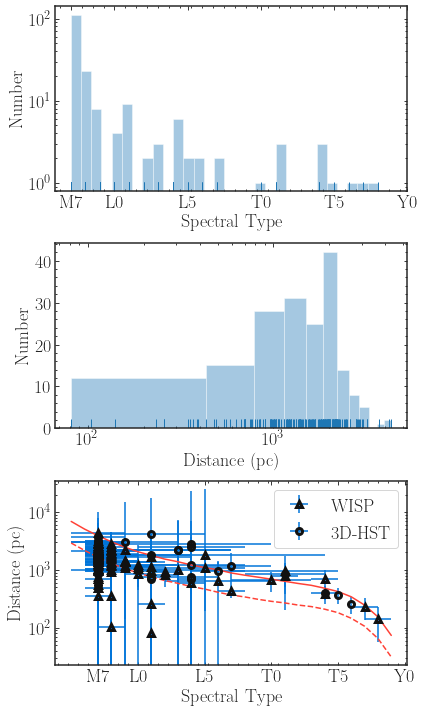

In [92]:
fig, (ax, ax1, ax2)=plt.subplots(nrows=3, figsize=(6, 10))
sns.distplot(ucds.spt, kde=False, ax=ax, rug=True, hist_kws={'align': 'mid'})
ax.set_xlabel('Spectral Type', fontsize=18)
ax.set_ylabel('Number', fontsize=18)
ax.minorticks_on()
ax.set_yscale('log')


sns.distplot(ucds.distance, kde=False, ax=ax1, rug=True, hist_kws={'align': 'mid'})
plt.tight_layout()
ax1.set_xlabel('Distance (pc)', fontsize=18)
ax1.set_ylabel('Number', fontsize=18)
ax1.minorticks_on()
ax1.set_xscale('log')

#for a in [ax, ax1]:
ax.set_xticks([17, 20, 25, 30, 35, 40])
ax.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])



ax2.plot(sp_grid, d_limitsdict.values, c='#FF4136', linestyle='--')
ax2.plot(sp_grid,  corrected_limits.values, c='#FF4136')

ax2.errorbar(wispsucd.spt, wispsucd.distance, yerr=wispsucd.distance_er , xerr= wispsucd.spt_er, label='WISP', fmt='^',  
             mec='#111111', mfc='none', mew=3, rasterized=True, c='#0074D9')
ax2.errorbar(hst3ducd.spt, hst3ducd.distance, yerr=hst3ducd.distance_er , xerr= hst3ducd.spt_er, label='3D-HST', fmt='o',
             mec='#111111',  mfc='none', mew=3, rasterized=True, c='#0074D9')
ax2.legend()


ax2.set_yscale('log')
ax2.set_ylabel('Distance (pc)', fontsize=18)
ax2.set_xlabel('Spectral Type', fontsize=18)

ax2.minorticks_on()

ax2.set_xticks([17, 20, 25, 30, 35, 40])
ax2.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/sptdistribution.pdf',  bbox_inches='tight')

[23.  3.]


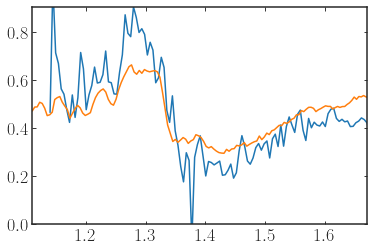

In [93]:
s=np.random.choice(ldwarfs.spectra.values)

m=s.flux[np.logical_and(s.wave >1.2, s.wave<1.65)].max()

std= splat.STDS_DWARF_SPEX[splat.typeToNum(s.spectral_type[0])]

std.normalize(waverange=[1.2, 1.6])


med0=(s.flux[np.logical_and(s.wave >1.2, s.wave <1.6) ]).mean()
med1=(std.flux.value[np.logical_and(std.wave.value >1.2, std.wave.value <1.6) ]).mean()

std.scale(med0/med1)
plt.plot(s.wave, s.flux)
plt.plot(std.wave.value, std.flux.value)
plt.xlim(1.11, 1.67)
plt.ylim([0., m])
print (s.spectral_type)

In [94]:
ucds.columns

Index(['H_2O-1/J-Cont', 'H_2O-1/J-Cont_er', 'H_2O-2/H_2O-1',
       'H_2O-2/H_2O-1_er', 'H-cont/H_2O-1', 'H-cont/H_2O-1_er', 'CH_4/H_2O-1',
       'CH_4/H_2O-1_er', 'H_2O-2/J-Cont', 'H_2O-2/J-Cont_er', 'H-cont/J-Cont',
       'H-cont/J-Cont_er', 'CH_4/J-Cont', 'CH_4/J-Cont_er', 'H-cont/H_2O-2',
       'H-cont/H_2O-2_er', 'CH_4/H_2O-2', 'CH_4/H_2O-2_er', 'CH_4/H-Cont',
       'CH_4/H-Cont_er', 'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/J-Cont_er',
       'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+H_2O-2/H-Cont_er', 'H_2O-1+CH_4/J-Cont',
       'H_2O-1+CH_4/J-Cont_er', 'H_2O-2+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont_er',
       'H_2O-1+CH_4/H-Cont', 'H_2O-1+CH_4/H-Cont_er', 'H_2O-2+CH_4/H-Cont',
       'H_2O-2+CH_4/H-Cont_er', 'spectra', 'grism_id', 'spt', 'spt_er',
       'distance', 'distance_er', 'coord', 'F110W', 'F110W_er', 'F160W',
       'F160W_er', 'F140W', 'F140W_er', 'snr1', 'snr2', 'snr3', 'snr4',
       'pointing', 'J', 'J_er', 'H', 'H_er', 'J_110', 'J_110_er'],
      dtype='object')

In [95]:
ldwarfs.spt_er.median()

2.0

In [96]:
ldwarfs.sort_values('spt_er',  ascending=False)[['snr1', 'snr2',  'spt', 'spt_er']]

,snr1,snr2,spt,spt_er
166,3.989462,4.081056,25.0,9.0
163,4.476141,3.044099,24.0,6.0
157,4.856791,4.202832,23.0,4.0
168,3.927631,3.901239,26.0,4.0
165,5.906550,4.788694,24.0,4.0
162,4.580164,3.846816,24.0,4.0
154,4.351430,3.313934,21.0,4.0
158,3.754193,3.459597,23.0,4.0
150,3.146260,3.385392,21.0,3.0
171,4.328465,4.238807,27.0,3.0


In [97]:
#import mplcyberpunk

#plt.style.use("cyberpunk")

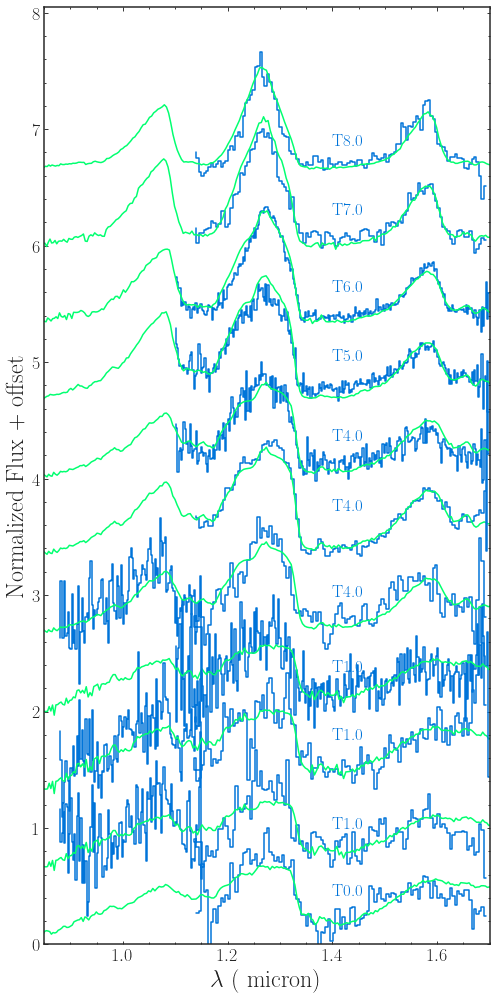

In [98]:
fig, ax=plt.subplots(figsize=(7, 14))

for  idx, y in enumerate(tdwarfs.spectra):
    x=y.splat_spectrum
    
    if x.wave.value.min()< 0.9:
        x.trim([0.88, 1.7])
        
    if x.wave.value.min()>0.9:
        x.trim([1.1, 1.7])
  
    std= splat.STDS_DWARF_SPEX[splat.typeToNum(y.spectral_type[0])]
    
    std.normalize(waverange=[1.15, 1.65])
    x.normalize(waverange=[1.15, 1.65])
    

    
    med0=(x.flux.value[np.logical_and(x.wave.value >1.15, x.wave.value <1.65) ]).mean()
    med1=(std.flux.value[np.logical_and(std.wave.value >1.15, std.wave.value <1.65) ]).mean()
    
    std.scale(med0/med1)
    
    plt.text(1.4, (x.flux.value+idx/1.5).mean(),splat.typeToNum(y.spectral_type[0]),
             {'fontsize':17, 'weight': 'bold'}, color='#0074D9')
    
    
    plt.step(x.wave.value, x.flux.value+idx/1.5, c='#0074D9')
    plt.plot(std.wave.value, std.flux.value+ idx/1.5, c='#01FF70')
    plt.ylim([0., 8.05])
    plt.xlim([0.85, 1.7])
    
plt.minorticks_on()
 
#mplcyberpunk.make_lines_glow(ax)
    
ax.set_xlabel(r'$\lambda$ ( micron)', fontsize=24)
ax.set_ylabel(r'Normalized Flux + offset', fontsize=24)

plt.tight_layout()  
#mplcyberpunk.add_underglow()
#mplcyberpunk.make_lines_glow(ax)
plt.savefig(wisps.OUTPUT_FIGURES+'/tdwarfsequence.pdf')

In [101]:
for xi in (ucds[ucds.spt_er> 4.]).spectra:
    print (xi.designation, xi.spectral_type, xi.snr['snr1'])

J10004273+0220589 [24.  6.] 4.476140563322827
J01253527-0001383 [25.  9.] 3.989462449799915


In [99]:
ghgjbkn

NameError: name 'ghgjbkn' is not defined

In [ ]:
len(ucds)

fig, ax=plt.subplots(figsize=(12, 16), ncols=2, sharey=False)

s=0
for  idx, y in enumerate(ldwarfs.spectra):
    a=ax[0]
    
    if idx>15:
        a=ax[1]
    
    x=y.splat_spectrum
    
    if x.wave.value.min()< 0.9:
        x.trim([0.88, 1.7])
        
    if x.wave.value.min()>0.9:
        x.trim([1.1, 1.7])
    
    std= splat.STDS_DWARF_SPEX[splat.typeToNum(y.spectral_type[0])]
    
    std.normalize(waverange=[1.2, 1.6])
    x.normalize(waverange=[1.2, 1.6])
    
    med0=(x.flux.value[np.logical_and(x.wave.value >1.2, x.wave.value <1.6) ]).mean()
    med1=(std.flux.value[np.logical_and(std.wave.value >1.2, std.wave.value <1.6) ]).mean()
    
    std.scale(med0/med1)

    
    a.text(1.4, med0+idx/1.5,splat.typeToNum(y.spectral_type[0]),
             {'fontsize':17, 'weight': 'bold'}, color='#0074D9')
    
    
    a.step(x.wave.value, x.flux.value+idx/1.5, c='#111111')
    a.plot(std.wave.value, std.flux.value+idx/1.5, c='#01FF70')
    
    a.minorticks_on()
    a.set_xlabel(r'$\lambda$ ( micron)', fontsize=24)
    a.set_ylabel(r'Normalized Flux + offset', fontsize=24)
    
    
    s=s+1
    
    
    
plt.minorticks_on()
 

    
ax[0].set_ylim([0.,11.5])
ax[0].set_xlim([0.8, 1.7])

ax[1].set_ylim([10.5, 20.5])
ax[1].set_xlim([0.8, 1.7])

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/ldwarfsequence.pdf')

In [ ]:
ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)
ucds['dof']=ucds.spectra.apply(lambda x: x.dof)
ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)
ucds['wavenumber']=ucds.spectra.apply(lambda x:len(x.wave))

In [ ]:
'''
%%capture
fold='/Users/caganze/research/wisps/figures/ltwarfs/'
ids=0
for idx, row in ucds.iterrows():
    try:
        s=row.spectra
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.pixels_per_image=100
        s.plot(save=True, filename=filename)
        ids=ids+1
    except:
        s=wisps.Source(filename=row.grism_id.replace('g141', 'G141'),is_ucd=False )
        s.pixels_per_image=100
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.plot(save=True, filename=filename)
        ids=ids+1
'''

In [ ]:
#ldwarfdata.to_pickle('~/desktop/wispldwarfs.pkl')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')

In [ ]:
ucds.grism_id.to_csv('~/desktop/true_brown_dwarfs.csv')

In [ ]:
len(ucds)